In [5]:
# SimPEG functionality
import simpeg.electromagnetics.time_domain as tdem
from simpeg import maps

# discretize functionality
from discretize import CylindricalMesh, TensorMesh

# Common Python functionality
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams.update({"font.size": 14})

In [11]:
# Source properties
source_location = np.array([0.0, 0.0, 0.0])  # (3, ) numpy.array_like
source_orientation = "z"  # "x", "y" or "z"
source_current = 1.0  # maximum on-time current (A)
source_radius = 25.0  # source loop radius (m)

# Receiver properties
receiver_locations = np.array([0.0, 0.0, 0.0])  # or (N, 3) numpy.ndarray
receiver_orientation = "z"  # "x", "y" or "z"
time_channels = np.logspace(-5, -3, 21)  # time channels (s)

# Model properties
halfspace_conductivity = 1  # Halfspace conductivity (S/m)

In [3]:
stepoff_waveform = tdem.sources.StepOffWaveform(off_time=0.0)

In [8]:
def generate_survey(waveform_object):
    # Define receiver
    receiver_list = [
        tdem.receivers.PointMagneticFluxTimeDerivative(
            receiver_locations, time_channels, orientation=receiver_orientation
        )
    ]

    # Define loop source
    source_list = [
        tdem.sources.CircularLoop(
            receiver_list=receiver_list,
            location=source_location,
            waveform=waveform_object,
            current=source_current,
            radius=source_radius,
        )
    ]

    return tdem.Survey(source_list)

In [20]:
def generate_discretization(dh, d_min, d_max):
    # Number of core mesh cells
    n_core = np.floor(8 * d_min / dh)

    # Number of padding cells
    n_pad = 1
    pad_factor = 1.25
    while sum(dh * pad_factor ** np.arange(n_pad)) < 2 * d_max:
        n_pad += 1

    # Radial and vertical discretization
    hr = [(dh, n_core), (dh, n_pad, 1.2)]
    hz = [(dh, n_pad, -pad_factor), (dh, 2 * n_core), (dh, n_pad, pad_factor)]

    # Generate mesh
    mesh = CylindricalMesh([hr, 1, hz], x0="00C")

    # Active cells
    active_cells = mesh.cell_centers[:, -1] < 0.0

    # Halfspace conductivity model
    model = halfspace_conductivity * np.ones(np.sum(active_cells))

    # Mapping from conductivity model to mesh
    mapping = maps.InjectActiveCells(mesh, active_cells, 1e-8)

    return mesh, model, mapping

In [16]:
diffusion_distances = 1260 * np.sqrt(time_channels / halfspace_conductivity)
d_min = diffusion_distances.min()
d_max = diffusion_distances.max()
print("DIFFUSION DISTANCES: {}".format(np.round(diffusion_distances, 1)))

DIFFUSION DISTANCES: [ 4.   4.5  5.   5.6  6.3  7.1  8.   8.9 10.  11.2 12.6 14.1 15.9 17.8
 20.  22.4 25.1 28.2 31.6 35.5 39.8]


In [17]:
size_factor = [4.0, 2.0, 1.0, 0.5, 0.25]
dh_min = [c * d_min for c in size_factor]

In [21]:
dpred_1 = []

for dh in dh_min:
    # Generate mesh, model and mapping
    mesh, model, mapping = generate_discretization(dh, d_min, d_max)

    # Define the simulation
    simulation = tdem.simulation.Simulation3DElectricField(
        mesh,
        survey=generate_survey(stepoff_waveform),
        sigmaMap=mapping,
        time_steps=[(5e-07, 40), (2.5e-06, 40), (1.25e-05, 81)],
    )

    # Simulate the data
    dpred_1.append(simulation.dpred(model))

    print("N_CELLS: {} | dh = {} m".format(mesh.nC, dh))

c:\Users\speci\AppData\Local\Programs\Python\Python312\Lib\site-packages\simpeg\base\pde_simulation.py:490: DefaultSolverWarning: Using the default solver: SolverLU. 

If you would like to suppress this notification, add 
warnings.filterwarnings('ignore', simpeg.utils.solver_utils.DefaultSolverWarning)
 to your script.
  return get_default_solver(warn=True)
c:\Users\speci\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymatsolver\wrappers.py:81: SparseEfficiencyWarning: splu converted its input to CSC format
  self.solver = fun(self.A, **self.kwargs)
c:\Users\speci\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymatsolver\solvers.py:415: FutureWarning: In Future pymatsolver v0.4.0, passing a vector of shape (n, 1) to the solve method will return an array with shape (n, 1), instead of always returning a flattened array. This is to be consistent with numpy.linalg.solve broadcasting.
  return self.solve(val)


N_CELLS: 72 | dh = 15.937879407248632 m
N_CELLS: 200 | dh = 7.968939703624316 m
N_CELLS: 578 | dh = 3.984469851812158 m
N_CELLS: 1458 | dh = 1.992234925906079 m
N_CELLS: 4232 | dh = 0.9961174629530395 m


In [22]:
simulation_1d = tdem.simulation_1d.Simulation1DLayered(
    survey=generate_survey(stepoff_waveform),
    thicknesses=[],
    sigmaMap=maps.IdentityMap(nP=1),
)

dtrue_stepoff = simulation_1d.dpred(np.array([halfspace_conductivity]))

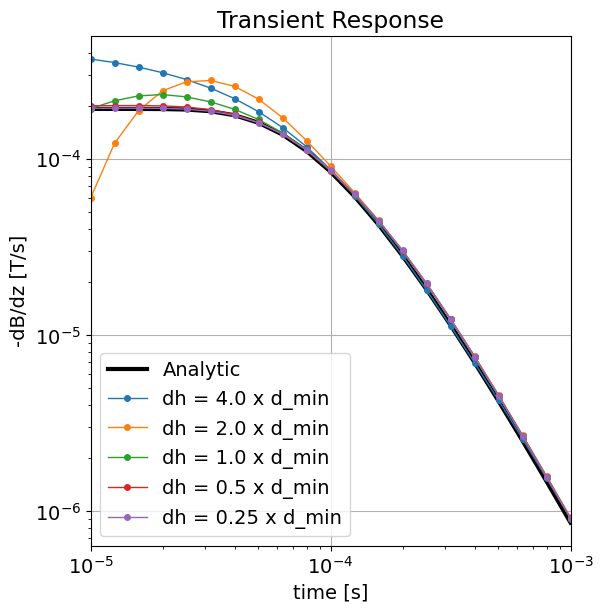

In [23]:
fig = plt.figure(figsize=(6, 6))
ax1 = fig.add_axes([0.1, 0.1, 0.8, 0.85])
ax1.loglog(time_channels, -dtrue_stepoff, "k", lw=3)
for d in dpred_1:
    ax1.loglog(time_channels, -d, "-o", lw=1, markersize=4)
ax1.set_xlim((np.min(time_channels), np.max(time_channels)))
ax1.grid()
ax1.set_xlabel("time [s]")
ax1.set_ylabel("-dB/dz [T/s]")
ax1.set_title("Transient Response")
ax1.legend(["Analytic"] + ["dh = {} x d_min".format(c) for c in size_factor])
plt.show()